<a href="https://colab.research.google.com/github/Haytam258/FashionMNIST-TinyVGG/blob/main/ComputerVisionAndCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll be using the FashionMNIST dataset in this Computer vision learning part.
We'll only have 1 color channel given that the dataset has black and white only images.

When we check our train_data, test_data, we see that it's a dataset object, so we'll need to use DataLoader in order to make a python iterable from that dataset.

More specifically, we want to turn our data into batches (mini-batches).

Why ?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).

2. It gives our neural network more chances to update its gradients per epoch. (If we're looking at 32 images at a time, it'll update the internal parameters every batch)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Image shape : torch.Size([1, 28, 28]) -> [Color_channels, height, width]
Image label : Ankle boot
Image size: torch.Size([1, 28, 28])
Label: 9


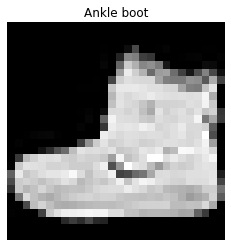

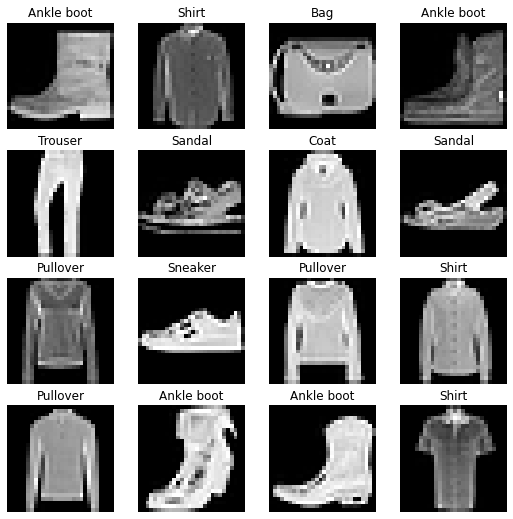

In [ ]:
import torch
from torch import nn

#Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#Import matplotlib
import matplotlib.pyplot as plt

#Import DataLoader
from torch.utils.data import DataLoader

#Setting up the training data 
train_data = datasets.FashionMNIST(root = "data", #Where to download the data ?
                                   train = True, #Do we want the training data ?
                                   download = True, #Do we want to download yes/no ?,
                                   transform = torchvision.transforms.ToTensor(), #How de we want to transform the data,
                                   target_transform = None #Do we want to transform the targets/labels ?
                                  )

#Setting up the testing data
test_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform = torchvision.transforms.ToTensor(),
    target_transform= None
)

image, label = train_data[0]

#Returns a dictionary that links each index to their respective label
class_to_idx = train_data.class_to_idx
class_names = train_data.classes
print(f"Image shape : {image.shape} -> [Color_channels, height, width]")
print(f"Image label : {class_names[label]}")

#Matplotlib either expects either no color channels (just height and width) or color channels last
#In our case, since it's grey-scale, we'll get rid of the extra dimension entirely
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)


#Plot this in grey-scale
plt.imshow(image.squeeze(), cmap = "gray")

#Plot more images randomly
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, lb = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[lb])
  plt.axis(False)

#Prepare the dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True) #We want to avoid having the model remember their order if they were ordered

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

#Check what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

#Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, lb = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[lb])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}")




## First model (Model0) : Baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model u will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary

So why do we flatten the data ?
-> It's because we'll be using a baseline model that has linear layers only, and it cannot handle multi-dimensional tensors


In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
x.shape

# Flatten the sample
output = flatten_model(x) # perform the forward pass

print(f"Shape before flattening : {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening : {output.shape} -> [color_channels, height*width]")

class FashionMNISTModelV0(nn.Module):
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, 
                  out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)


torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape = 784, #This is 28*28
                             hidden_units = 10,
                             output_shape = len(class_names) ).to("cpu")


# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.1)


Shape before flattening : torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening : torch.Size([1, 784]) -> [color_channels, height*width]


### Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer
import requests
from pathlib import Path
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time. """
  total_time = end - start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

start_time = timer()
#some code ...
end_time = timer()
print_train_time(start= start_time,
                 end = end_time,
                 device = "cpu")
if Path("helper_functions.py").is_file():
  print("Already exists")
else :
  print("Downloading the file ...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Train time on cpu : 0.000 seconds


### Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the tess loss *per batch*
4. Print out what's happening
5. Time it all

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch} \n-------")

  # Training
  train_loss = 0

  # Add a loop to loop through the training batches, we enumerate the loader to know which batch we're on (that's why we have "batch" in the loop)
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # Forward pass
    y_pred = model_0(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss  #This will give us the average loss per batch once we divide it per batch

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
    
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)


  # Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      test_pred = model_0(X_test)
      
      # Calculate the loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # Calculate the accuracy (in the helper_functions.py file, might have to download it again)
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))
    
    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)
  
  # Print
  print(f"\nTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.5904 | Test loss : 0.5095, Test acc: 82.0387
Epoch : 1 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.4763 | Test loss : 0.4799, Test acc: 83.1969
Epoch : 2 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.4550 | Test loss : 0.4766, Test acc: 83.4265
Train time on cpu : 23.525 seconds


### Make predictions and get Model0 results

In [ ]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

def evalModel(model: torch.nn.Module,
              data_loader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device : torch.device = device):
  """Returns a dictionary containing the results of model predicting on data_loader"""
  loss = 0
  acc = 0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      # Make data device agnostic
      X, y = X.to(device), y.to(device)
      
      # Make predictions
      y_pred = model(X).to(device)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                      y_pred = y_pred.argmax(dim= 1).to(device))
      
    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name" : model.__class__.__name__,
          "model_loss" : loss.item(),
          "model_acc" : acc} # model name only works when model was created with a class

model_0_results = evalModel(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                            device = "cpu")

  0%|          | 0/313 [00:00<?, ?it/s]

### Setup device agnostic code and testing the speed with a new model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_feat : int, output_feat : int, hidden_units = 8):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_feat, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_feat),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)


model1 = FashionMNISTModelV1(input_feat = 784, output_feat = len(class_names), hidden_units = 10).to(device) # class_names = train_data.classes

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.1)

train_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch} \n-------")

  train_loss = 0

  for batch, (X,y) in enumerate(train_dataloader):
    
    y_pred = model1(X.to(device)).to(device)

    loss = loss_fn(y_pred, y.to(device))

    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
  
  train_loss /= len(train_dataloader)
  
  test_loss, test_acc = 0,0

  model1.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model1(X_test.to(device)).to(device)

      test_loss += loss_fn(test_pred, y_test.to(device))

      test_acc += accuracy_fn(y_true = y_test.to(device),
                              y_pred = test_pred.argmax(dim=1))
      
    test_acc /= len(test_dataloader)
    test_loss /= len(test_dataloader)

    print(f"\nTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f}, Test acc: {test_acc:.4f}")
  
train_end = timer()
total_train_time_model_1 = print_train_time(start=train_start,
                                            end=train_end,
                                            device=str(next(model1.parameters()).device))





  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.9122 | Test loss : 0.7401, Test acc: 73.0232
Epoch : 1 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.6426 | Test loss : 0.4825, Test acc: 82.9872
Epoch : 2 
-------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss : 0.4574 | Test loss : 0.4642, Test acc: 83.3866
Train time on cuda:0 : 30.966 seconds


### Turning training and testing loop into functions

-Keep in mind that it is best practice to make the training and testing loop into fucntions in your projects, as it helps keep errors to a minimum (i mean, when we were testing with the new model1, we had a bunch of errors related to device so having a device-agnostic training loop function would be a good idea)

-We'll call it `train_step()` and `test_step()`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  
  """Performs a training step with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0

  # Put model into training mode

  model.train()

  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim=1))
    
    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Divide total train loss and accuracy to get the average per batch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train acc : {train_acc:.2f}%")


In [ ]:
def test_step(model: torch.nn.Module,
              test_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over test_loader"""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X_test, y_test in test_loader:
      # Send data to target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      test_pred = model(X_test)

      # Calculate the loss/acc
      test_acc += accuracy_fn(y_true = y_test,
                              y_pred = test_pred.argmax(dim=1)) # Logits -> prediction labels
      test_loss += loss_fn(test_pred, y_test)

    # Remain within the context manager(otherwise pytorch will throw an error since we're modifying variables local to the context), adjust metrics and print out
    test_acc /= len(test_loader)
    test_loss /= len(test_loader)
    print(f"Test loss :{test_loss:.5f} | Test acc : {test_acc:.2f}% ")
  


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why ?

1. It could be that the overhead for copying data/model to and from the GPU outweight the compute benefits offered by the GPU (it has to copy the data that is originally in the CPU to the GPU, while it might compute faster, the copy time offsets it).

2. The hardware you're using has a better CPU in terms of compute capability than the GPU.

In [ ]:
for epoch in tqdm(range(epochs)):
  train_step(model = model1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model1,
            test_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss : 0.42885 | Train acc : 84.64%
Test loss :0.46213 | Test acc : 83.45% 
Train loss : 0.41603 | Train acc : 84.95%
Test loss :0.47615 | Test acc : 83.08% 
Train loss : 0.40512 | Train acc : 85.39%
Test loss :0.46166 | Test acc : 83.75% 


### Model 2 : Building a Convolutional Neural Network (CNN) 

CNN's are also known as ConvNets.

CNN's are also known for their ability to find patterns in Visual data.

This website explains the inner workings of the CNN : https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural network

class FashionMNISTModelV2(nn.Module):
  """ Model architecture that replicates the TinyVGG Model from CNN explainer website."""
  def __init__(self, input_shape : int, output_shape :int, hidden_units :int):
    super().__init__()
    # We often refere to blocks which you can think of as a stack of layers.
    # An architecture is a combination of Blocks, and a Block is a combination of layers. 
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1), # Conv2d because we're working 2D data (2 dimensional (height and width))
        nn.ReLU(),
        nn.Conv2d( in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3, 
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    # Classifier is also known as the output layer (since it'll classify the output into one of the labels)
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7, # There's a trick to calculating this ! U create a dummy tensor and pass it through the model and print the shapes that go through the forward pass in each block
                  out_features = output_shape)
    )

  # Notice how there's the flatten layer before the linear layer, meaning that there will be multiplication and reduction of the dimensions
  # The 7*7 comes from the flattening
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_layer(x)
    return x


torch.manual_seed(42)

# The input for the CNN here is the color channels, in our case since we only have 1 color channels, the input_shape will be 1

model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

### Stepping through the `Conv2d()`



In [ ]:
torch.manual_seed(42)

# Create a batch of images (Batch size, color channels (it's pytorch), Height, Width)
images = torch.randn(size=(32,3,64,64))

test_image = images[0]
# Let's check the images' shape
print(f"Image batch shape : {images.shape}")
print(f"Test image shape : {test_image.shape}")

# Create a single conv2d layer (in_channels is the color channels)
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0)

Image batch shape : torch.Size([32, 3, 64, 64])
Test image shape : torch.Size([3, 64, 64])


### Stepping through the `nn.MaxPool2d()`

In [ ]:
# Create a sample of nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass data through just the conv layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer and maxpool layer {test_image_through_conv_and_max_pool.shape}")



Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer and maxpool layer torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size = (1, 1, 2, 2))


# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool shape : {max_pool_tensor.shape}")


Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool shape : torch.Size([1, 1, 1, 1])


The Convolutional layer tries to learn the features of the image, then we pass those learned features into the max pool layer in order to compress them. It'll learn the compressed representation of the input in order to predict the class / label of the input image

In [ ]:
from timeit import default_timer as timer
# Setup the training function and the optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

# Training and testing with train_step, test_step

torch.manual_seed(42)

train_time_start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_2,
            test_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end = timer()
total_train_time = print_train_time(start = train_time_start,
                                    end = train_time_end,
                                    device = device)





  0%|          | 0/3 [00:00<?, ?it/s]

Train loss : 0.59460 | Train acc : 78.36%
Test loss :0.39455 | Test acc : 85.98% 
Train loss : 0.36380 | Train acc : 86.83%
Test loss :0.34807 | Test acc : 86.97% 
Train loss : 0.32473 | Train acc : 88.33%
Test loss :0.31701 | Test acc : 88.45% 
Train time on cuda : 34.952 seconds


In [ ]:
def make_predictions(model : torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model will give raw logits)
      pred_logit = model(sample)

      # Get prediction probability( logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

(-0.5, 27.5, 27.5, -0.5)

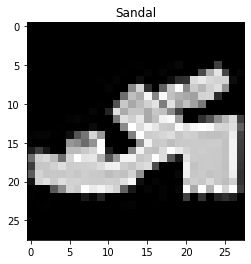

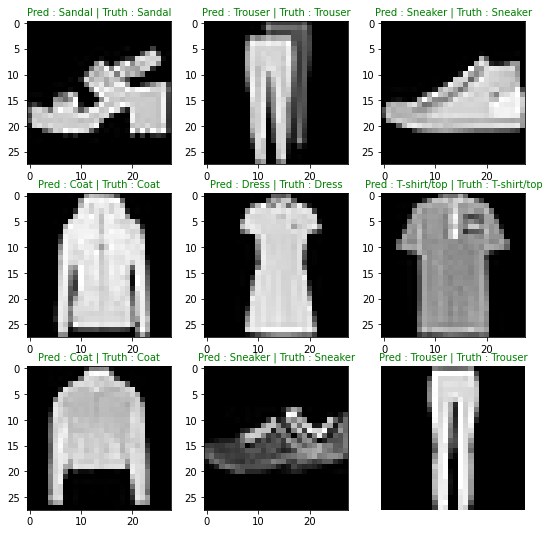

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

# Make predictions
pred_probs = make_predictions(model = model_2,
                              data=test_samples)

# View first two prediction probabilities 
pred_probs[:2]
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim = 1)


# Plot predictions 
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred : {pred_label} | Truth : {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g") # Green text if the prediction is the same
  else :
    plt.title(title_text, fontsize = 10, c = "r") 
plt.axis(False)


### Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evalutating your classification models visually.

1. Make predictions with our trained model on the test dataset.
2. Make confusion matrix using the torchmetrics.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`


In [ ]:
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model_2(X)

    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim=1)

    # Put predictions on CPU for evalutation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
# See if the required packages are installed and if not, install them ...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version : {mlxtend.__version__} ")
  assert int(mlxtend.__version__.split(".")[1] >= 19), "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version : {mlxtend.__version__} ")

     |████████████████████████████████| 419 kB 27.1 MB/s 
     |████████████████████████████████| 1.3 MB 66.7 MB/s 
mlxtend version : 0.20.0 


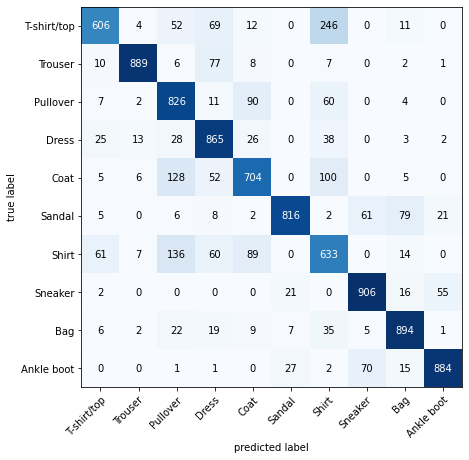

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), # Matplotlib likes numpy
                                class_names = class_names,
                                figsize=(10,7))

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

### Save and load best performing model

In [ ]:
from pathlib import Path
# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "CNNModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), 
           f = MODEL_SAVE_PATH)

Saving model to models/CNNModel.pth


In [ ]:
loaded_model = FashionMNISTModelV2(input_shape = 1, output_shape = len(class_names), hidden_units = 10)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>